### Load Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import statsmodels.api as sm
from pylab import rcParams
import warnings
import datetime
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

warnings.filterwarnings("ignore")
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})

### Load dataset

In [2]:
df=pd.read_csv('euro_exchange_rate.csv')
df.head()

,Date,USD,JPY,BGN,CYP,CZK,DKK,EEK,GBP,HUF,...,INR,KRW,MXN,MYR,NZD,PHP,SGD,THB,ZAR,Unnamed: 42
0,2023-03-23,1.0879,142.87,1.9558,NaN,23.658,7.4482,NaN,0.88523,384.75,...,89.4810,1396.18,20.1915,4.8063,1.7373,59.125,1.4434,37.119,19.7787,NaN
1,2023-03-22,1.0785,143.13,1.9558,NaN,23.722,7.4472,NaN,0.87925,388.55,...,89.0800,1406.43,20.0036,4.8047,1.7362,58.683,1.4391,37.100,19.8529,NaN
2,2023-03-21,1.0776,142.63,1.9558,NaN,23.846,7.4465,NaN,0.88033,391.58,...,89.0308,1406.34,20.1454,4.8196,1.7412,58.485,1.4392,36.929,19.9659,NaN
3,2023-03-20,1.0717,140.77,1.9558,NaN,23.988,7.4450,NaN,0.87560,399.21,...,88.4900,1401.82,20.3003,4.8076,1.7106,58.281,1.4354,36.513,19.7861,NaN
4,2023-03-17,1.0623,140.57,1.9558,NaN,23.948,7.4450,NaN,0.87488,395.93,...,87.7870,1389.84,19.9829,4.7649,1.7014,58.118,1.4262,36.246,19.4988,NaN


### Clean data

In [3]:
df=df.drop('Unnamed: 42', axis=1)
df.columns

Index(['Date', 'USD', 'JPY', 'BGN', 'CYP', 'CZK', 'DKK', 'EEK', 'GBP', 'HUF',
       'LTL', 'LVL', 'MTL', 'PLN', 'ROL', 'RON', 'SEK', 'SIT', 'SKK', 'CHF',
       'ISK', 'NOK', 'HRK', 'RUB', 'TRL', 'TRY', 'AUD', 'BRL', 'CAD', 'CNY',
       'HKD', 'IDR', 'ILS', 'INR', 'KRW', 'MXN', 'MYR', 'NZD', 'PHP', 'SGD',
       'THB', 'ZAR'],
      dtype='object')

In [4]:
df.isnull().sum()

Date       0
USD        0
JPY        0
BGN      398
CYP     3902
CZK        0
DKK        0
EEK     3132
GBP        0
HUF        0
LTL     2109
LVL     2364
MTL     3902
PLN        0
ROL     4542
RON     1664
SEK        0
SIT     4157
SKK     3646
CHF        0
ISK     2341
NOK        0
HRK     1658
RUB     1873
TRL     4669
TRY     1537
AUD        0
BRL     2304
CAD        0
CNY     1599
HKD        0
IDR     1599
ILS     3074
INR     2560
KRW        0
MXN     2304
MYR     1599
NZD        0
PHP     1599
SGD        0
THB     1599
ZAR        0
dtype: int64

In [5]:
# Print full rows having NULL entries in the df
is_NaN = df.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df[row_has_NaN]

In [6]:
print(rows_with_NaN)

            Date     USD     JPY     BGN      CYP     CZK     DKK      EEK  \
0     2023-03-23  1.0879  142.87  1.9558      NaN  23.658  7.4482      NaN   
1     2023-03-22  1.0785  143.13  1.9558      NaN  23.722  7.4472      NaN   
2     2023-03-21  1.0776  142.63  1.9558      NaN  23.846  7.4465      NaN   
3     2023-03-20  1.0717  140.77  1.9558      NaN  23.988  7.4450      NaN   
4     2023-03-17  1.0623  140.57  1.9558      NaN  23.948  7.4450      NaN   
...          ...     ...     ...     ...      ...     ...     ...      ...   
6201  1999-01-08  1.1659  130.09     NaN  0.58187  34.938  7.4433  15.6466   
6202  1999-01-07  1.1632  129.43     NaN  0.58187  34.886  7.4431  15.6466   
6203  1999-01-06  1.1743  131.42     NaN  0.58200  34.850  7.4452  15.6466   
6204  1999-01-05  1.1790  130.96     NaN  0.58230  34.917  7.4495  15.6466   
6205  1999-01-04  1.1789  133.73     NaN  0.58231  35.107  7.4501  15.6466   

          GBP     HUF  ...     ILS      INR      KRW      MXN  

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6206 entries, 0 to 6205
Data columns (total 42 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    6206 non-null   object 
 1   USD     6206 non-null   float64
 2   JPY     6206 non-null   float64
 3   BGN     5808 non-null   float64
 4   CYP     2304 non-null   float64
 5   CZK     6206 non-null   float64
 6   DKK     6206 non-null   float64
 7   EEK     3074 non-null   float64
 8   GBP     6206 non-null   float64
 9   HUF     6206 non-null   float64
 10  LTL     4097 non-null   float64
 11  LVL     3842 non-null   float64
 12  MTL     2304 non-null   float64
 13  PLN     6206 non-null   float64
 14  ROL     1664 non-null   float64
 15  RON     4542 non-null   float64
 16  SEK     6206 non-null   float64
 17  SIT     2049 non-null   float64
 18  SKK     2560 non-null   float64
 19  CHF     6206 non-null   float64
 20  ISK     3865 non-null   float64
 21  NOK     6206 non-null   float64
 22  

In [8]:
df5=df.loc[:,['Date','USD', 'JPY', 'GBP', 'AUD', 'CAD']]
#df5.Date = pd.to_datetime(df5.Date)
df5.Date = pd.to_datetime(df5.Date, infer_datetime_format=True)
df5


,Date,USD,JPY,GBP,AUD,CAD
0,2023-03-23,1.0879,142.87,0.88523,1.6242,1.4875
1,2023-03-22,1.0785,143.13,0.87925,1.6132,1.4782
2,2023-03-21,1.0776,142.63,0.88033,1.6136,1.4726
3,2023-03-20,1.0717,140.77,0.87560,1.5978,1.4669
4,2023-03-17,1.0623,140.57,0.87488,1.5874,1.4584
...,...,...,...,...,...,...
6201,1999-01-08,1.1659,130.09,0.70940,1.8406,1.7643
6202,1999-01-07,1.1632,129.43,0.70585,1.8474,1.7602
6203,1999-01-06,1.1743,131.42,0.70760,1.8820,1.7711
6204,1999-01-05,1.1790,130.96,0.71220,1.8944,1.7965


### Visualise the data

In [9]:
df5_list = ['USD', 'JPY', 'GBP', 'AUD', 'CAD']

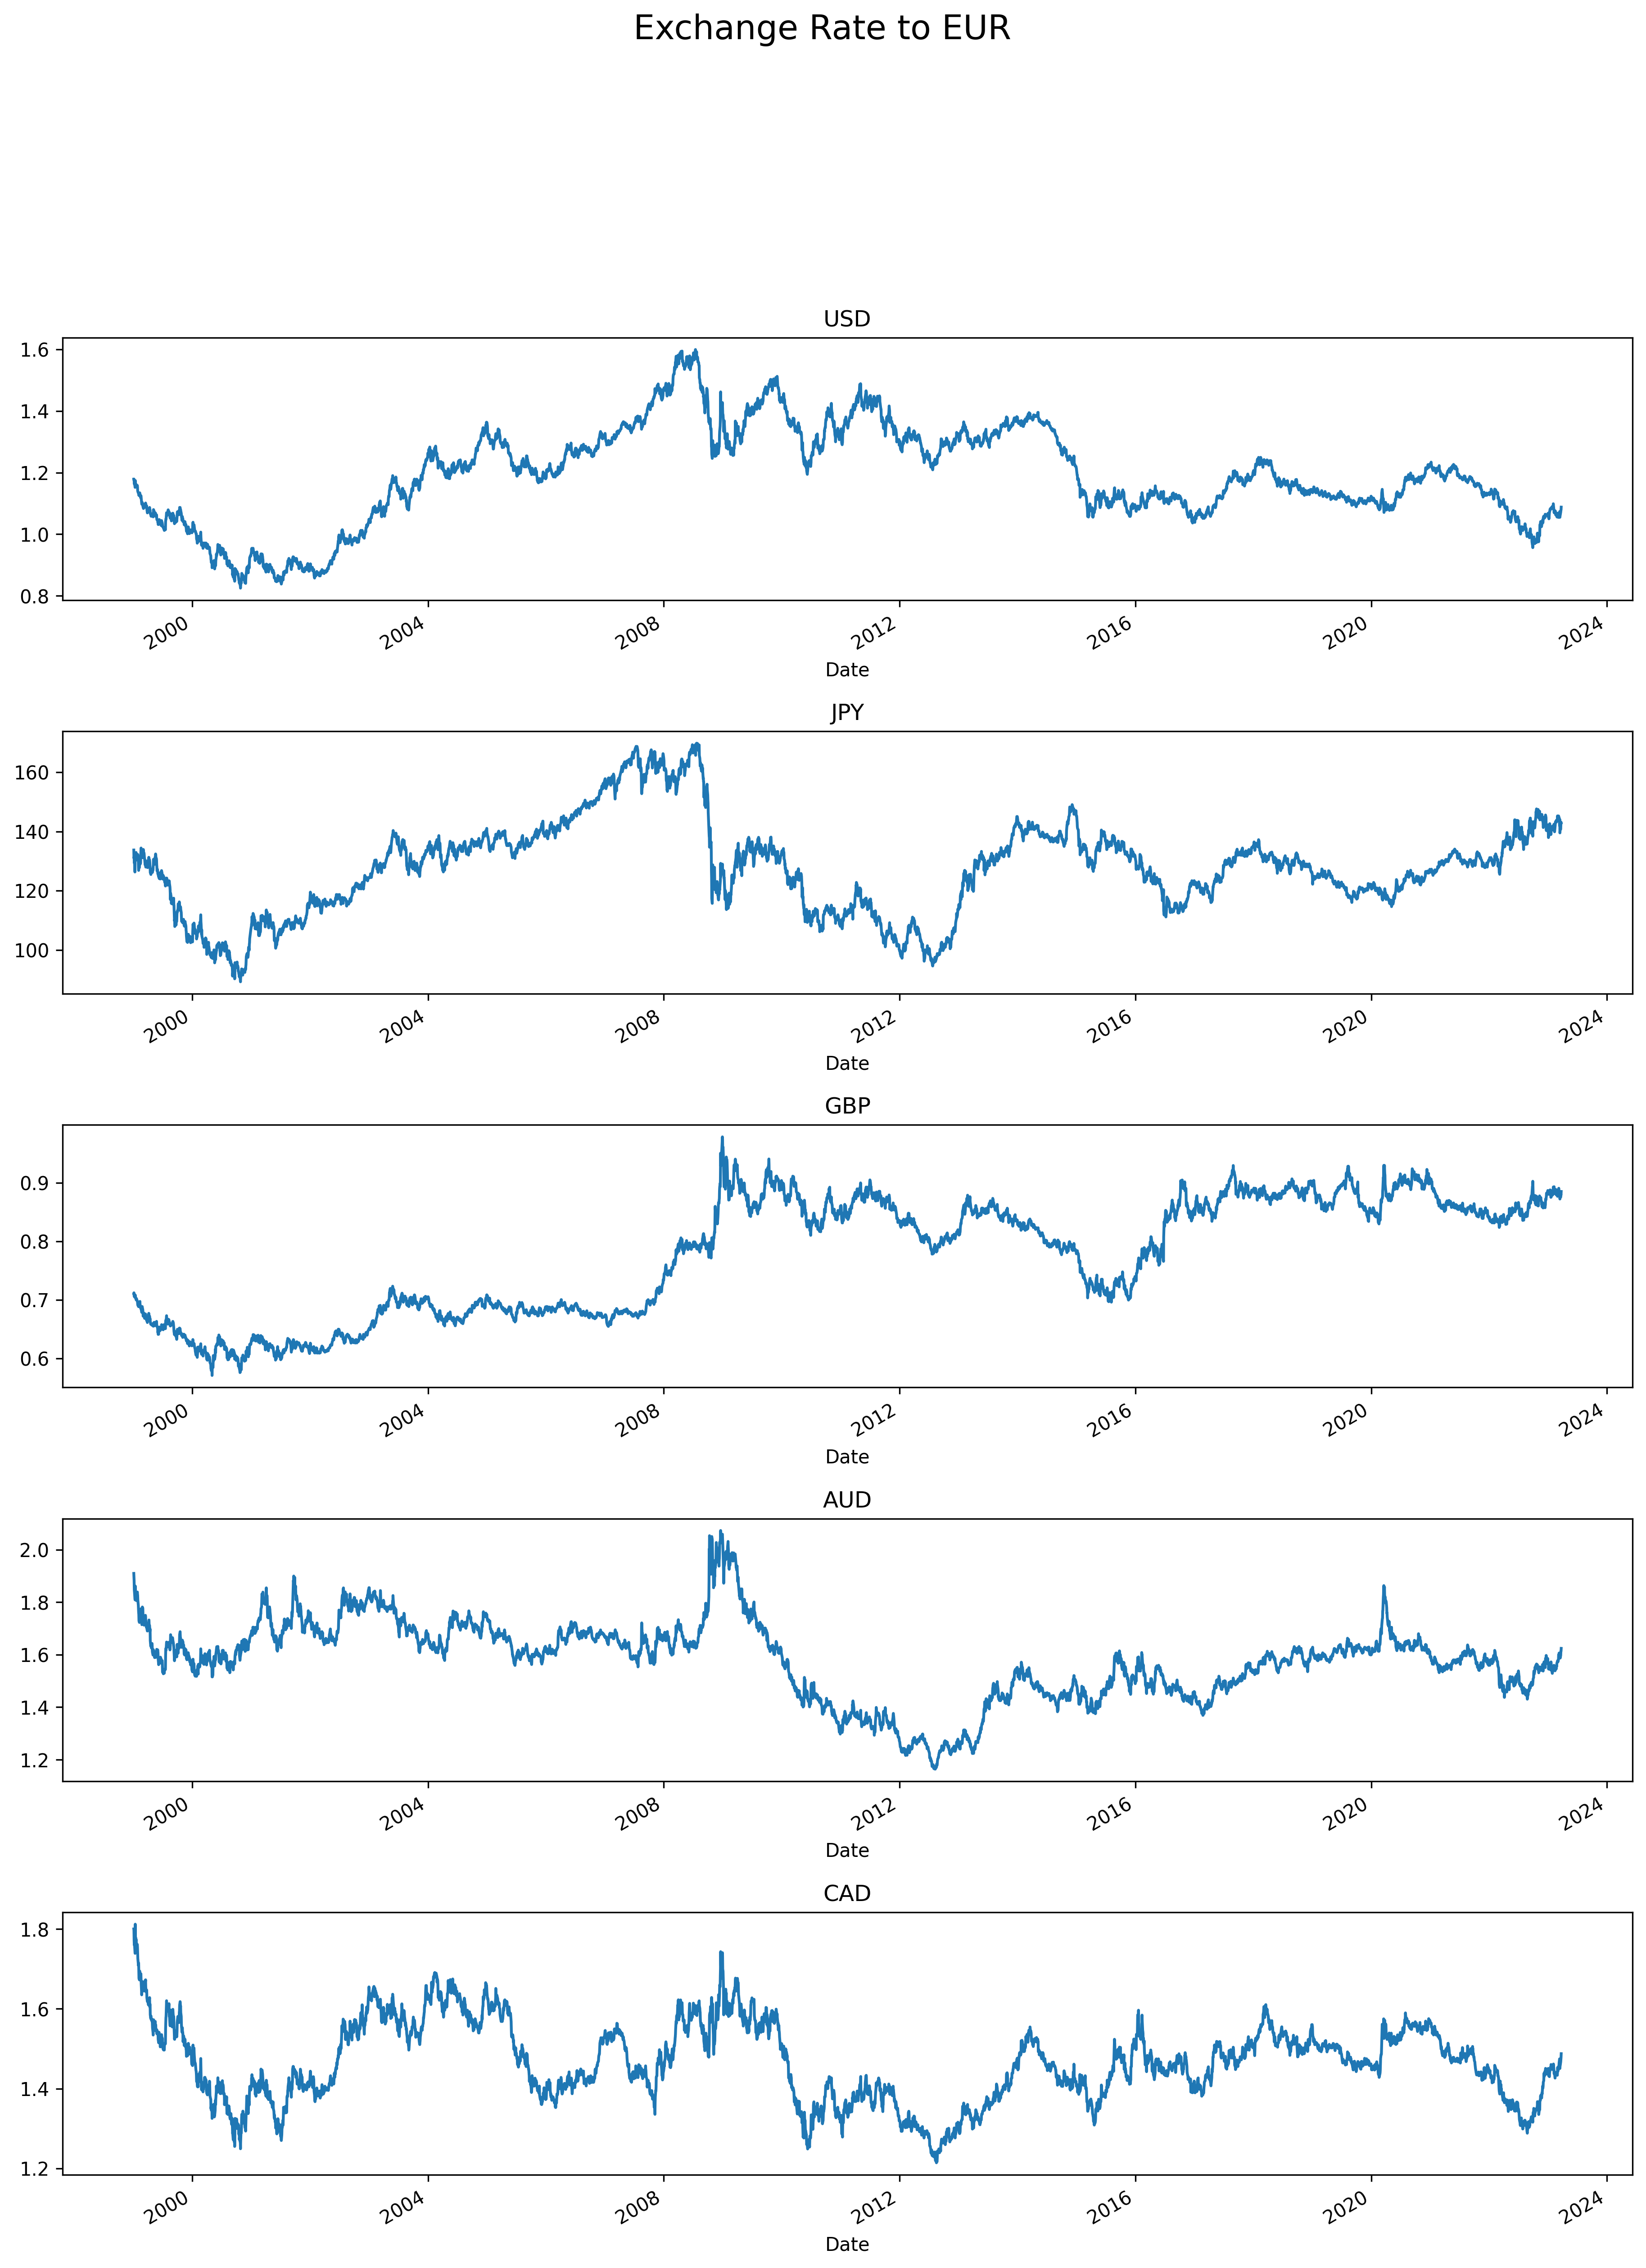

In [10]:
plt.figure(figsize=(15,20))
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Exchange Rate to EUR', fontsize=18,y=1)

# loop through the length of currencies and keep track of index
for n, currency in enumerate(df5_list):
    # add new subplot iteratively
    ax = plt.subplot(5,1,n+1)
    df5.plot(x='Date',y=currency,ax=ax, legend=None)
    # chart formating
    ax.set_title(currency.upper()) 

### Resample the data

Daily data for time series usually contains too much variation. Therefore, Iresampled by week. This resampled time series will be used to predict the exchange rate against the EUR.

Resampling the time series data based on weekly frequency <br>
'W' indicates week and find the mean exchange rate of each week <br>

In [11]:
weekly= pd.DataFrame()
weekly = df5.set_index('Date').resample('M', label='left').mean()  # label left for start date
pd.date_range(start='1999-01-03', end='2023-03-19', freq='M').difference(weekly.index)
weekly

,USD,JPY,GBP,AUD,CAD
Date,,,,,
1998-12-31,1.160780,131.348500,0.702912,1.838730,1.764610
1999-01-31,1.120765,130.778000,0.688505,1.751460,1.678560
1999-02-28,1.088296,130.198696,0.671270,1.726004,1.651000
1999-03-31,1.070441,128.159545,0.665018,1.668364,1.594386
1999-04-30,1.062810,129.714286,0.658252,1.604586,1.552657
...,...,...,...,...,...
2022-10-31,1.020127,145.124091,0.868921,1.545473,1.370827
2022-11-30,1.058881,142.822381,0.869500,1.568519,1.437862
2022-12-31,1.076900,140.544091,0.882123,1.552264,1.447409


In [12]:
weekly.shape

(291, 5)

In [13]:
df_USD =weekly['USD']
df_USD

Date
1998-12-31    1.160780
1999-01-31    1.120765
1999-02-28    1.088296
1999-03-31    1.070441
1999-04-30    1.062810
                ...   
2022-10-31    1.020127
2022-11-30    1.058881
2022-12-31    1.076900
2023-01-31    1.071510
2023-02-28    1.066276
Freq: M, Name: USD, Length: 291, dtype: float64

In [14]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

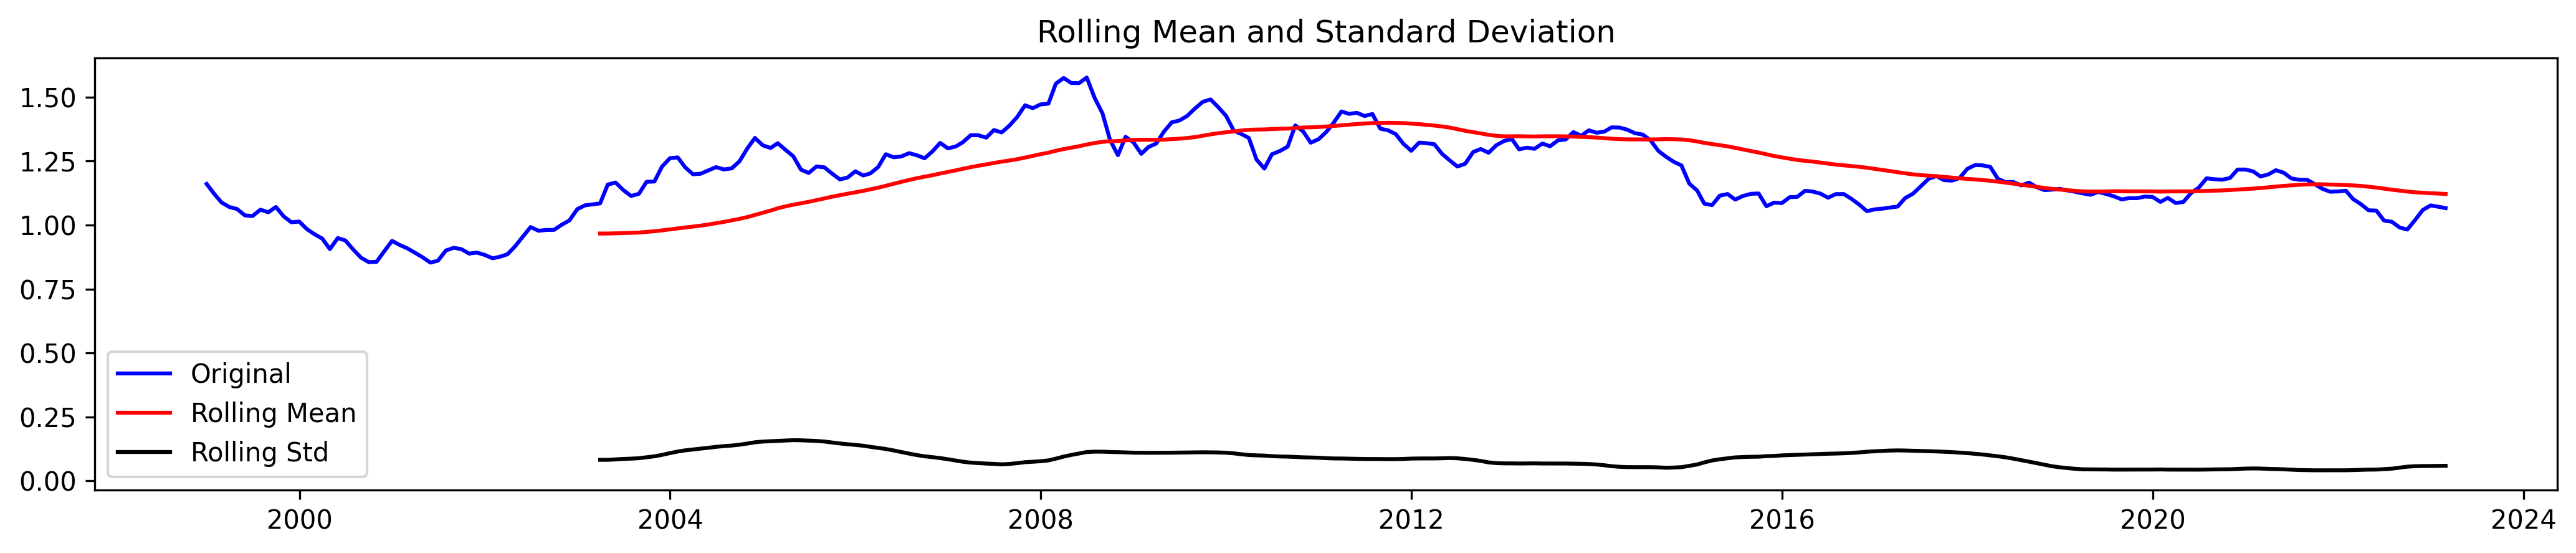

Results of dickey fuller test
Test Statistics                 -1.938446
p-value                          0.314197
No. of lags used                 1.000000
Number of observations used    289.000000
critical value (1%)             -3.453182
critical value (5%)             -2.871593
critical value (10%)            -2.572127
dtype: float64


In [15]:
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(52).mean()
    rolstd = timeseries.rolling(52).std()
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_USD)

<Figure size 5100x900 with 0 Axes>

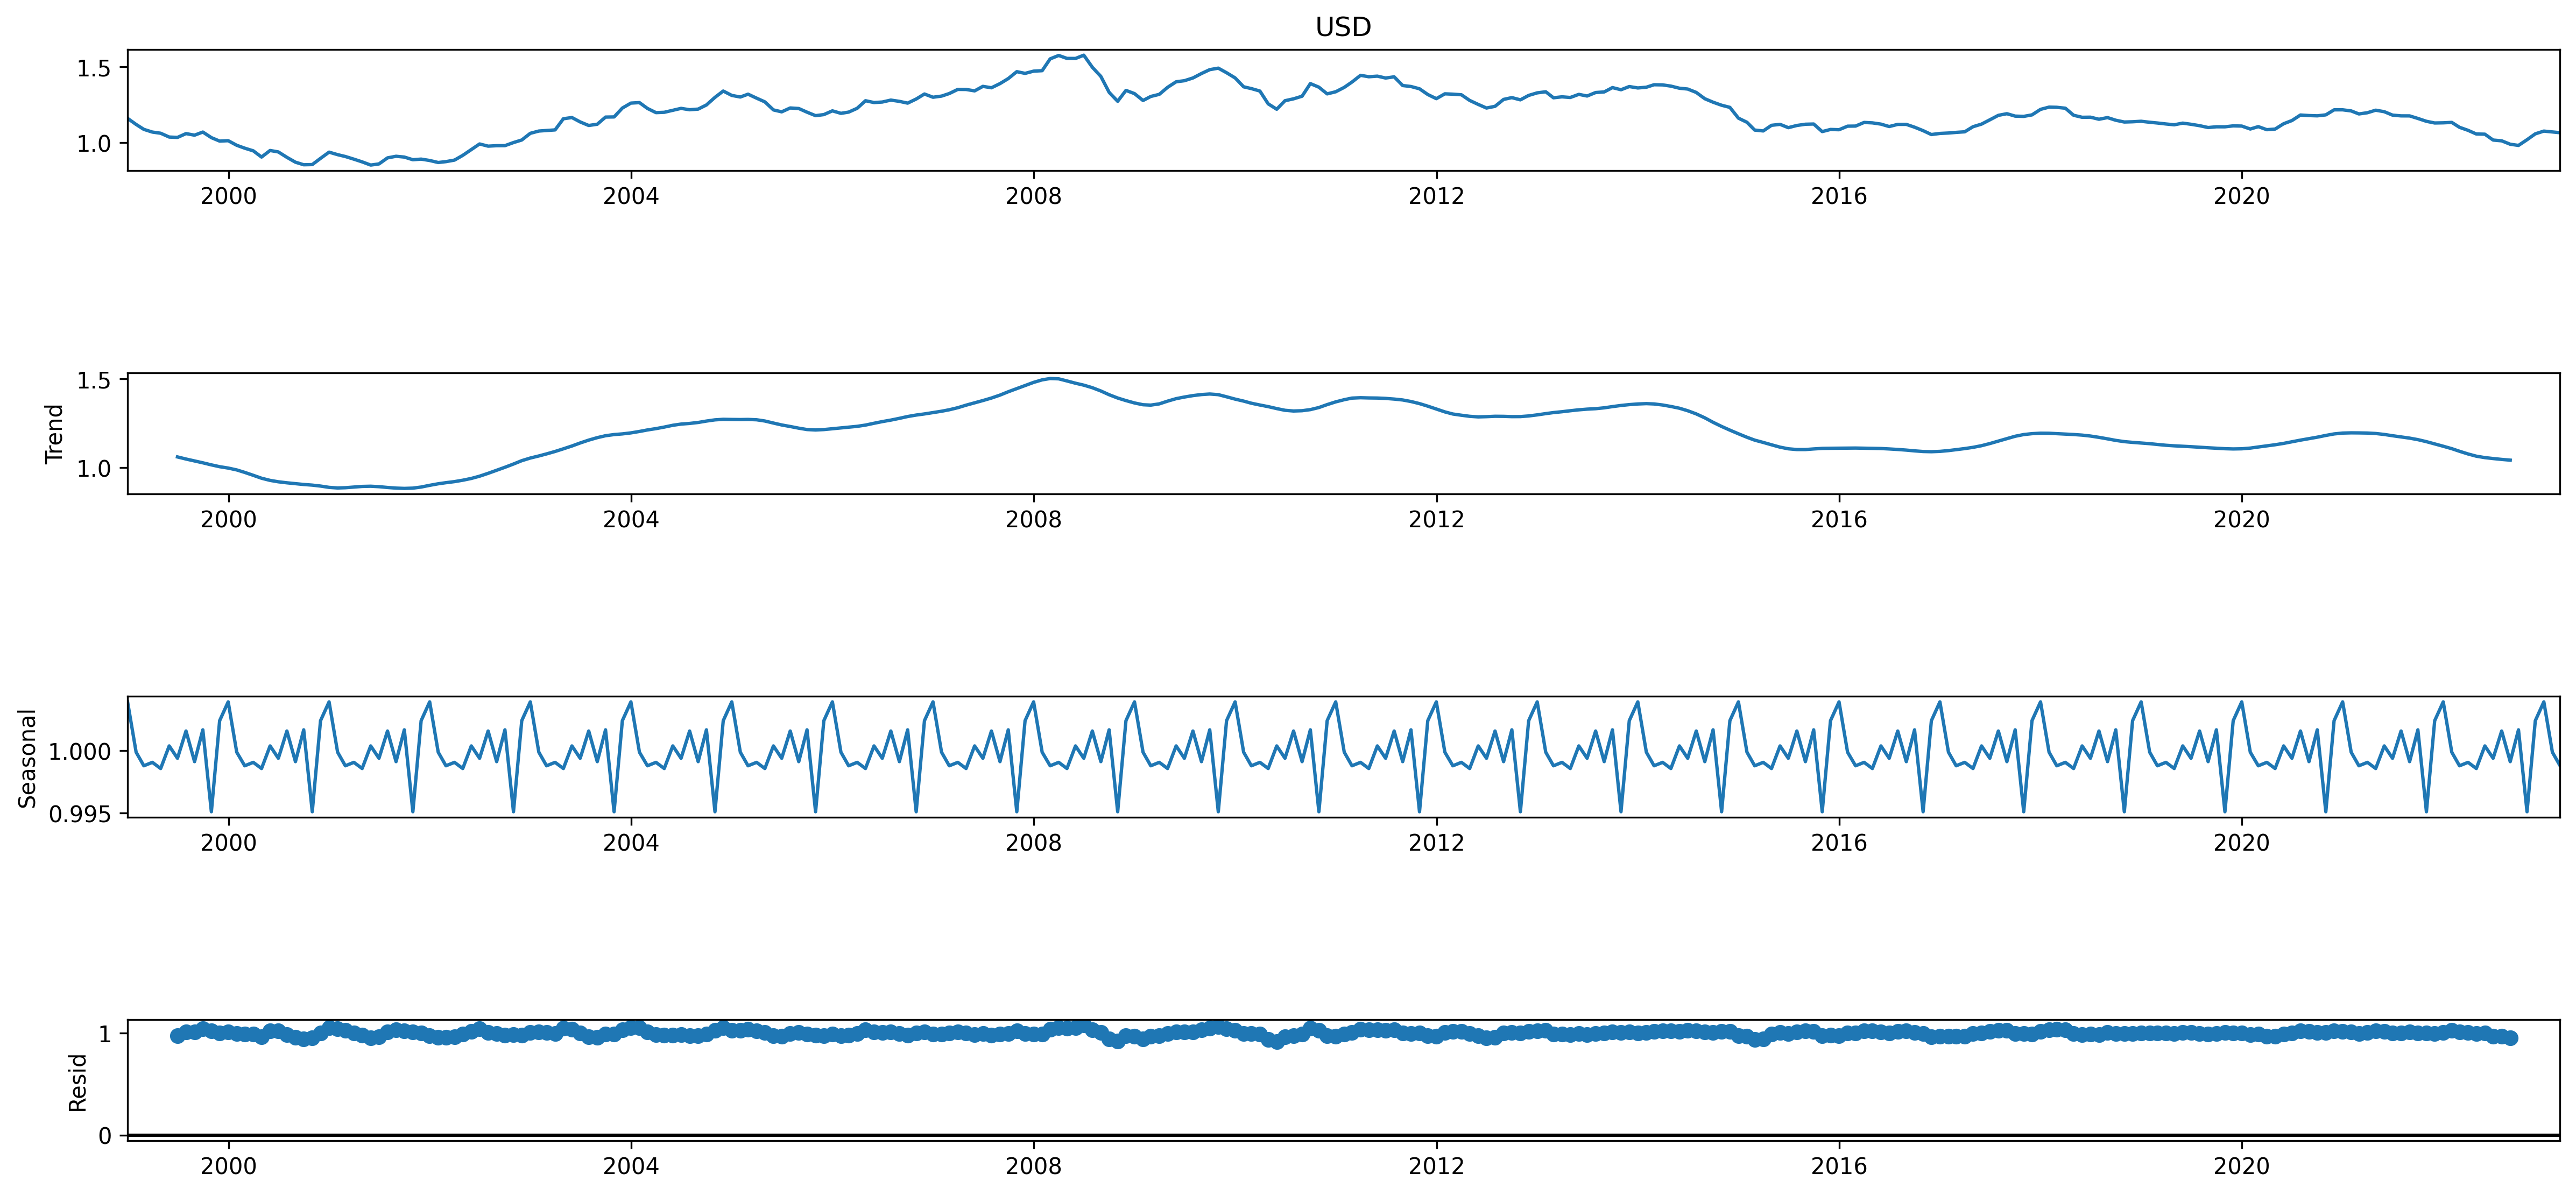

In [16]:
result = seasonal_decompose(df_USD,model='multiplicative')
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


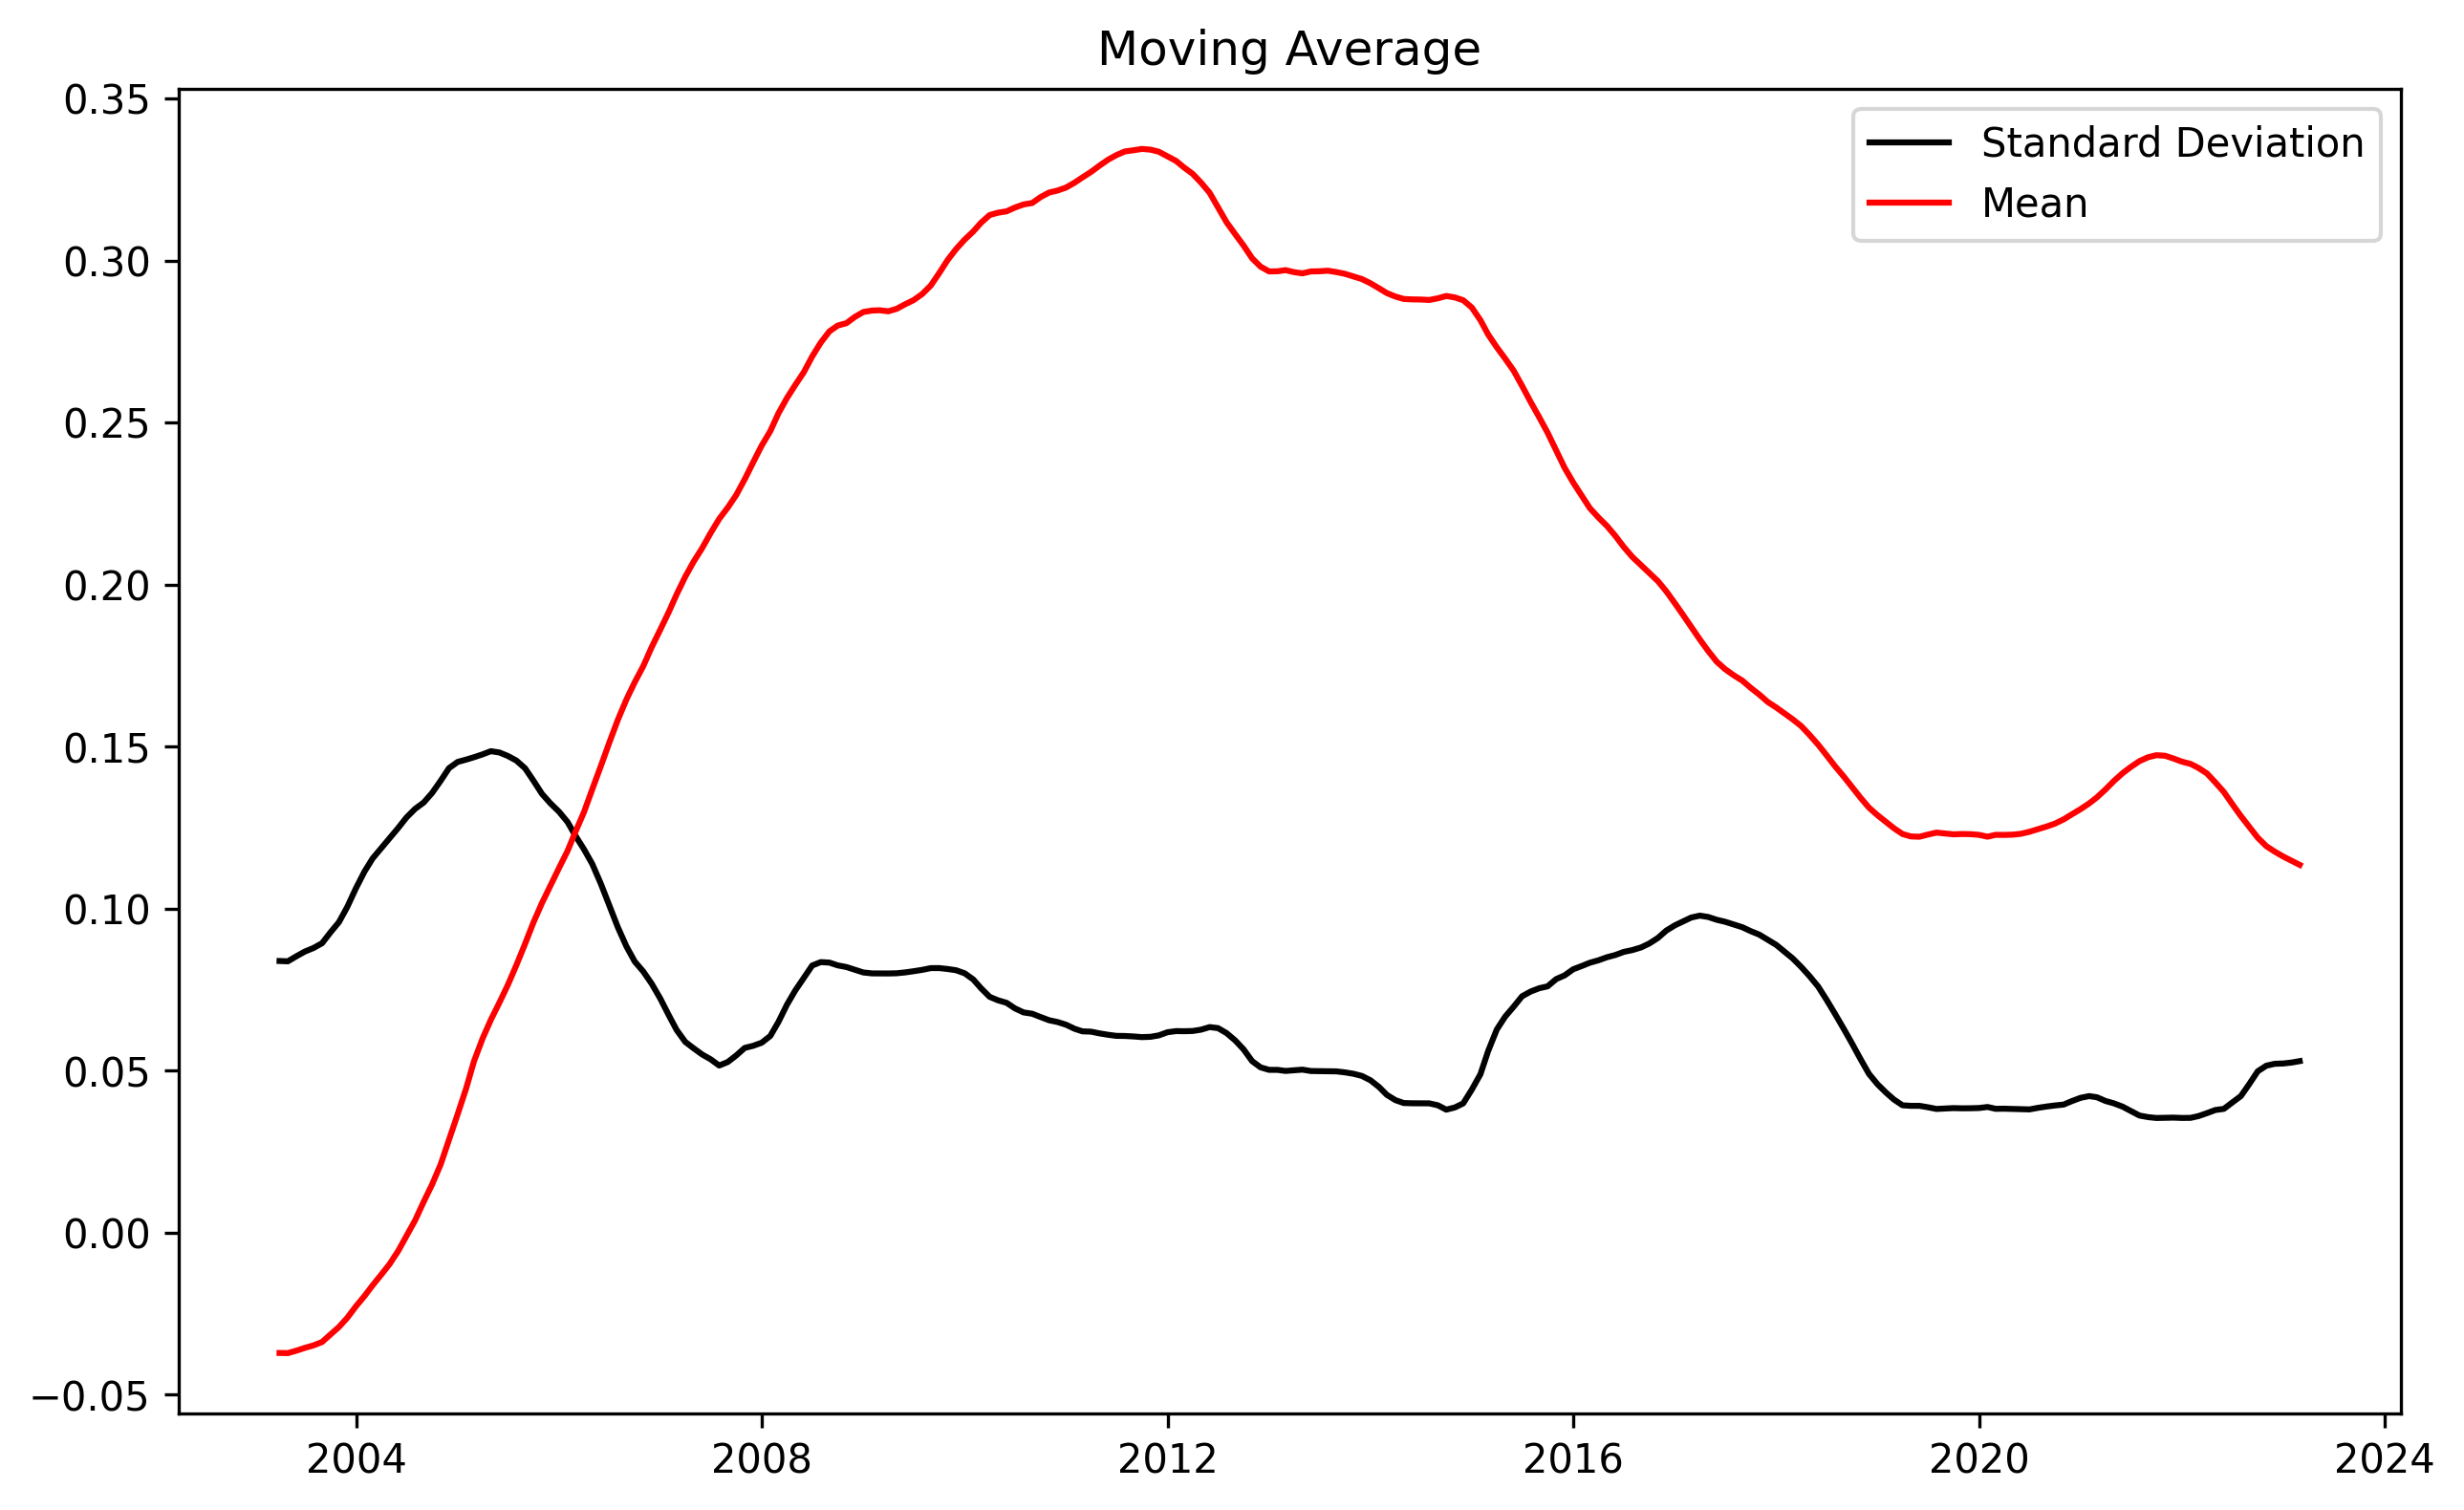

In [17]:
#use log to stabilize the time series and make it stationary
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_USD_log = np.log(df_USD)
moving_avg = df_USD_log.rolling(52).mean()
std_dev = df_USD_log.rolling(52).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

In [38]:
train_data, test_data = df_USD_log[2:int(len(df_USD_log)*0.9)], df_USD_log[int(len(df_USD_log)*0.9):]

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1218.022, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1238.555, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1239.685, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1219.973, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1237.844, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1237.884, Time=0.27 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1235.932, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-1241.660, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1239.823, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-1239.854, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-1240.533, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-1237.898, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.179 seconds
                               SARIMAX Results                              

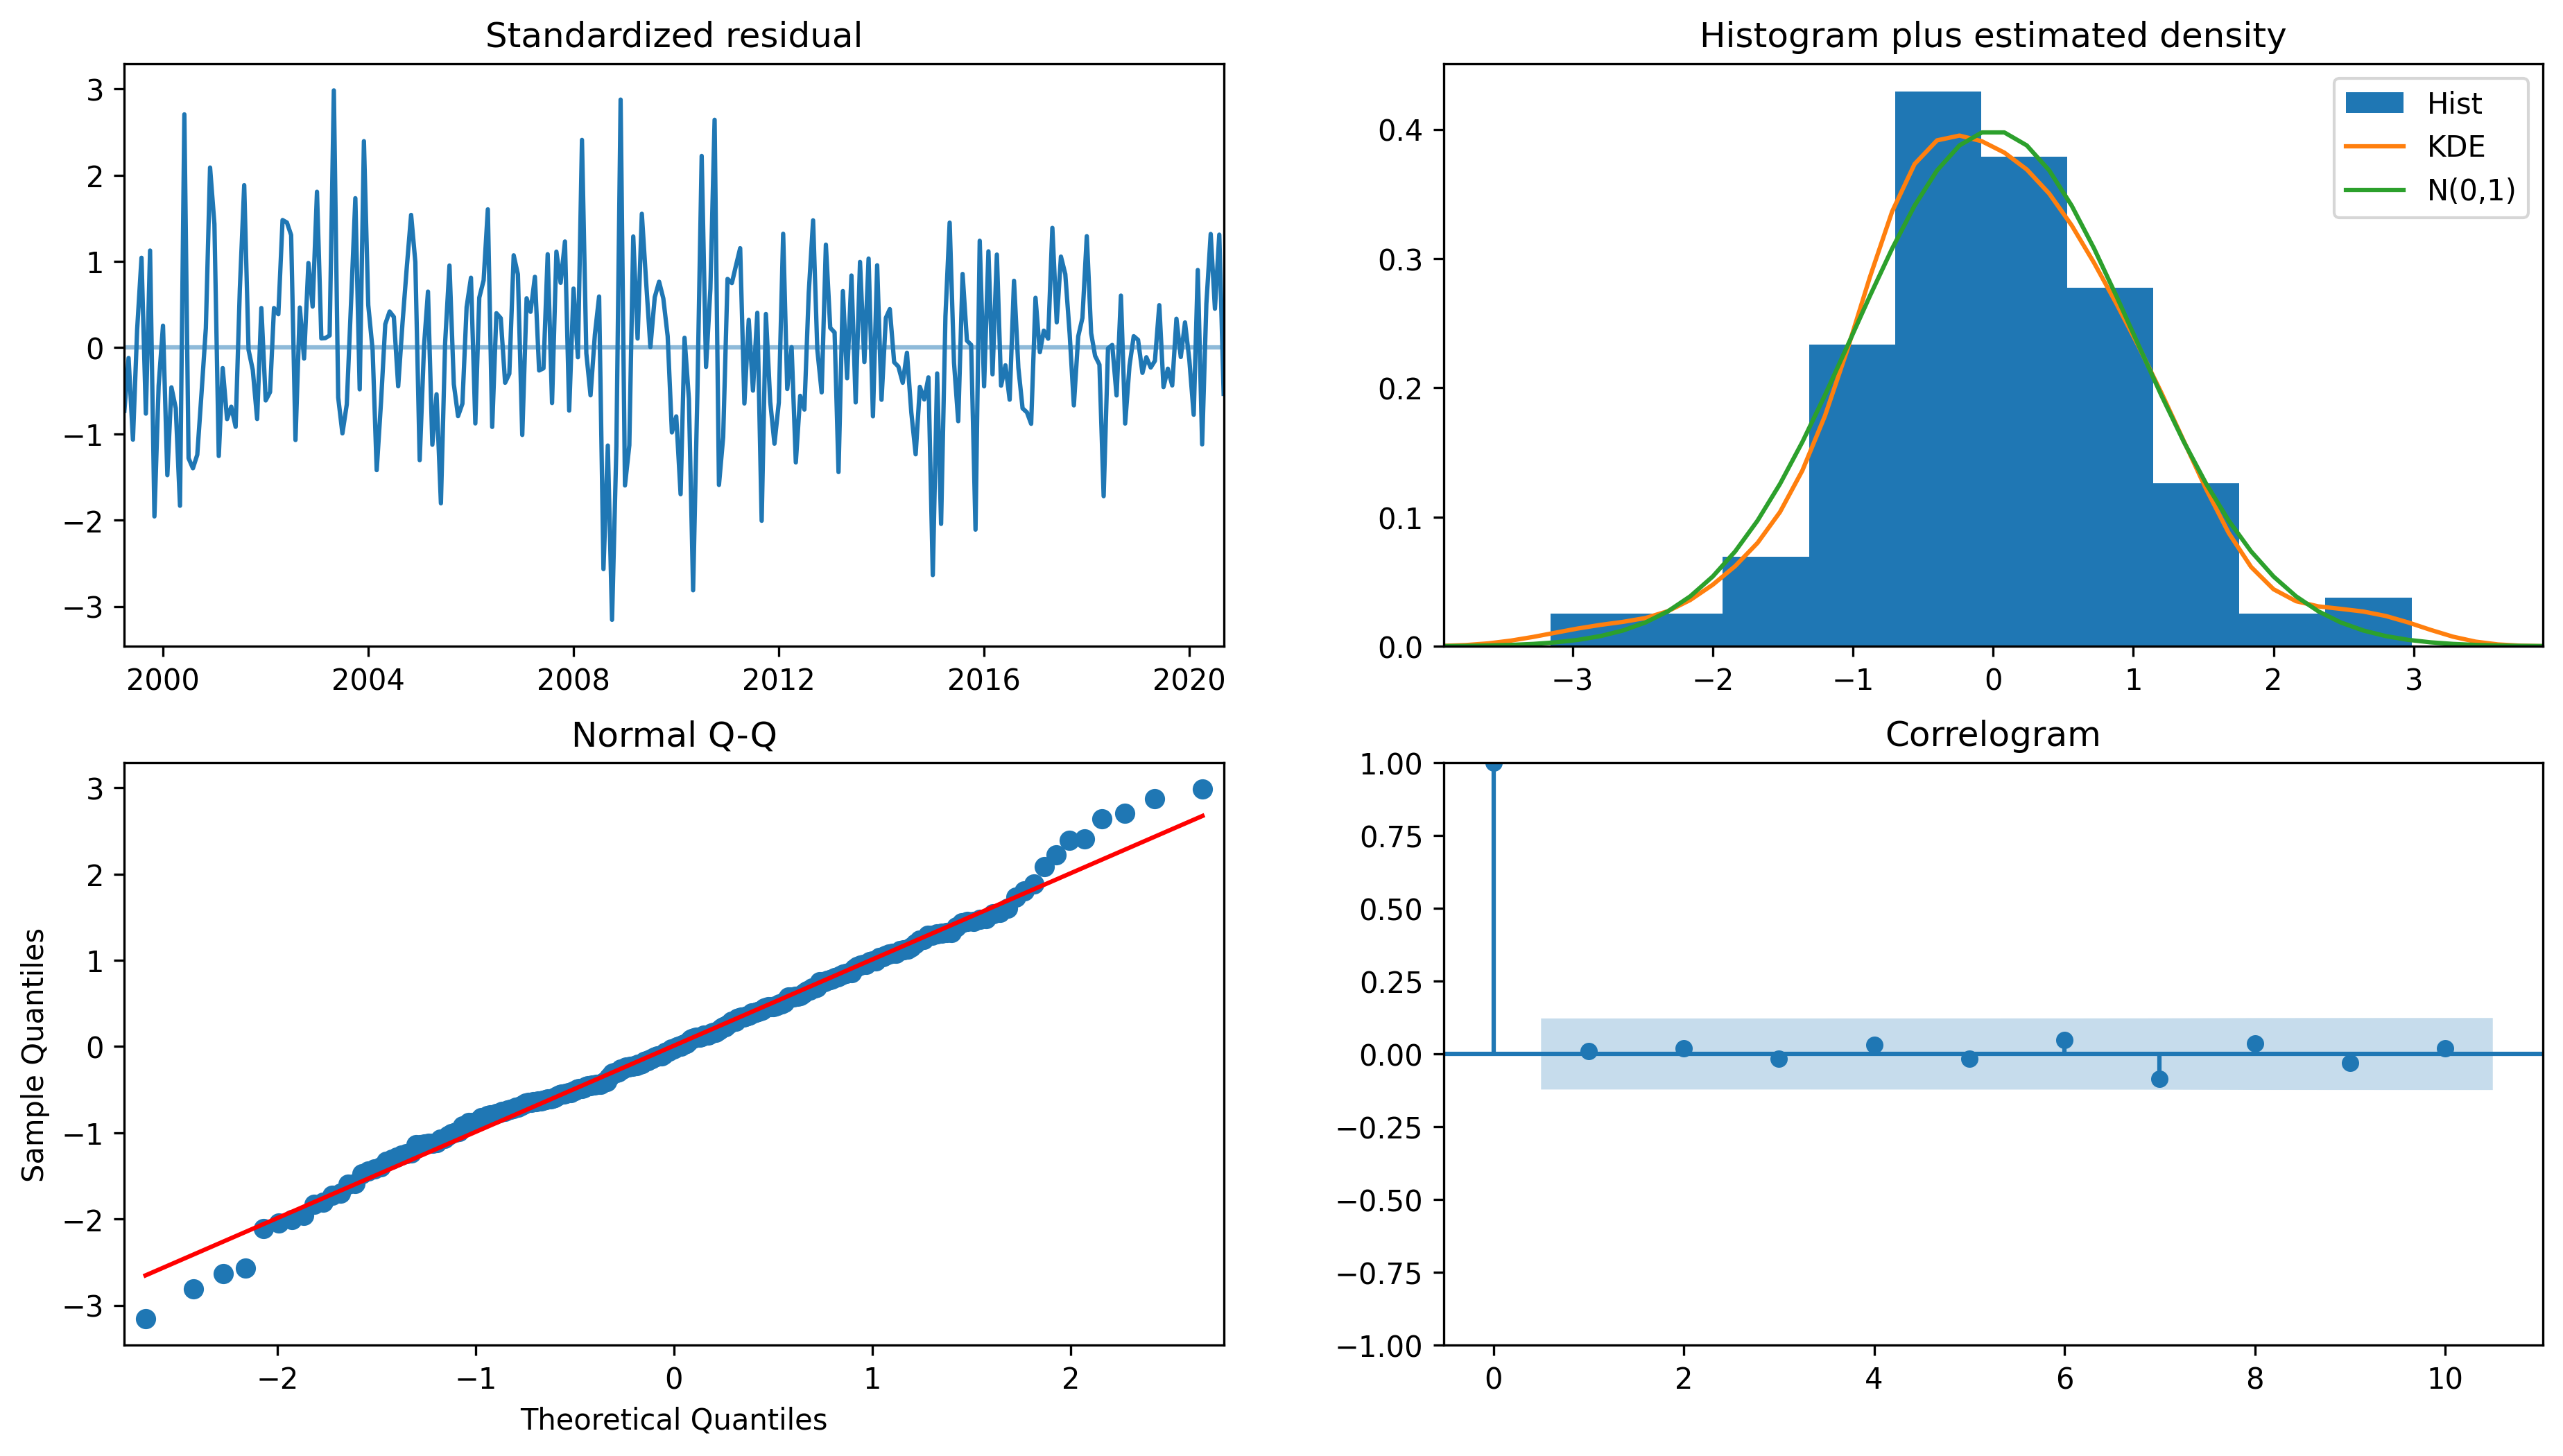

In [40]:
#create an instance of Auto arima
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [41]:
from statsmodels.tsa.arima.model import ARIMA

ARIMA_model = ARIMA(train_data, order=(0,1,1))  
fitted = ARIMA_model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                    USD   No. Observations:                  259
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 622.830
Date:                Wed, 03 May 2023   AIC                          -1241.660
Time:                        19:58:09   BIC                          -1234.554
Sample:                    02-28-1999   HQIC                         -1238.803
                         - 08-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3015      0.064      4.748      0.000       0.177       0.426
sigma2         0.0005   3.62e-05     12.922      0.000       0.000       0.001
Ljung-Box (L1) (Q):                   0.02   Jarque-

In [25]:
samples=len(test_data)
fc=fitted.forecast(samples, alpha=0.05)

In [26]:
fc_series = pd.Series(fc, index=test_data.index)

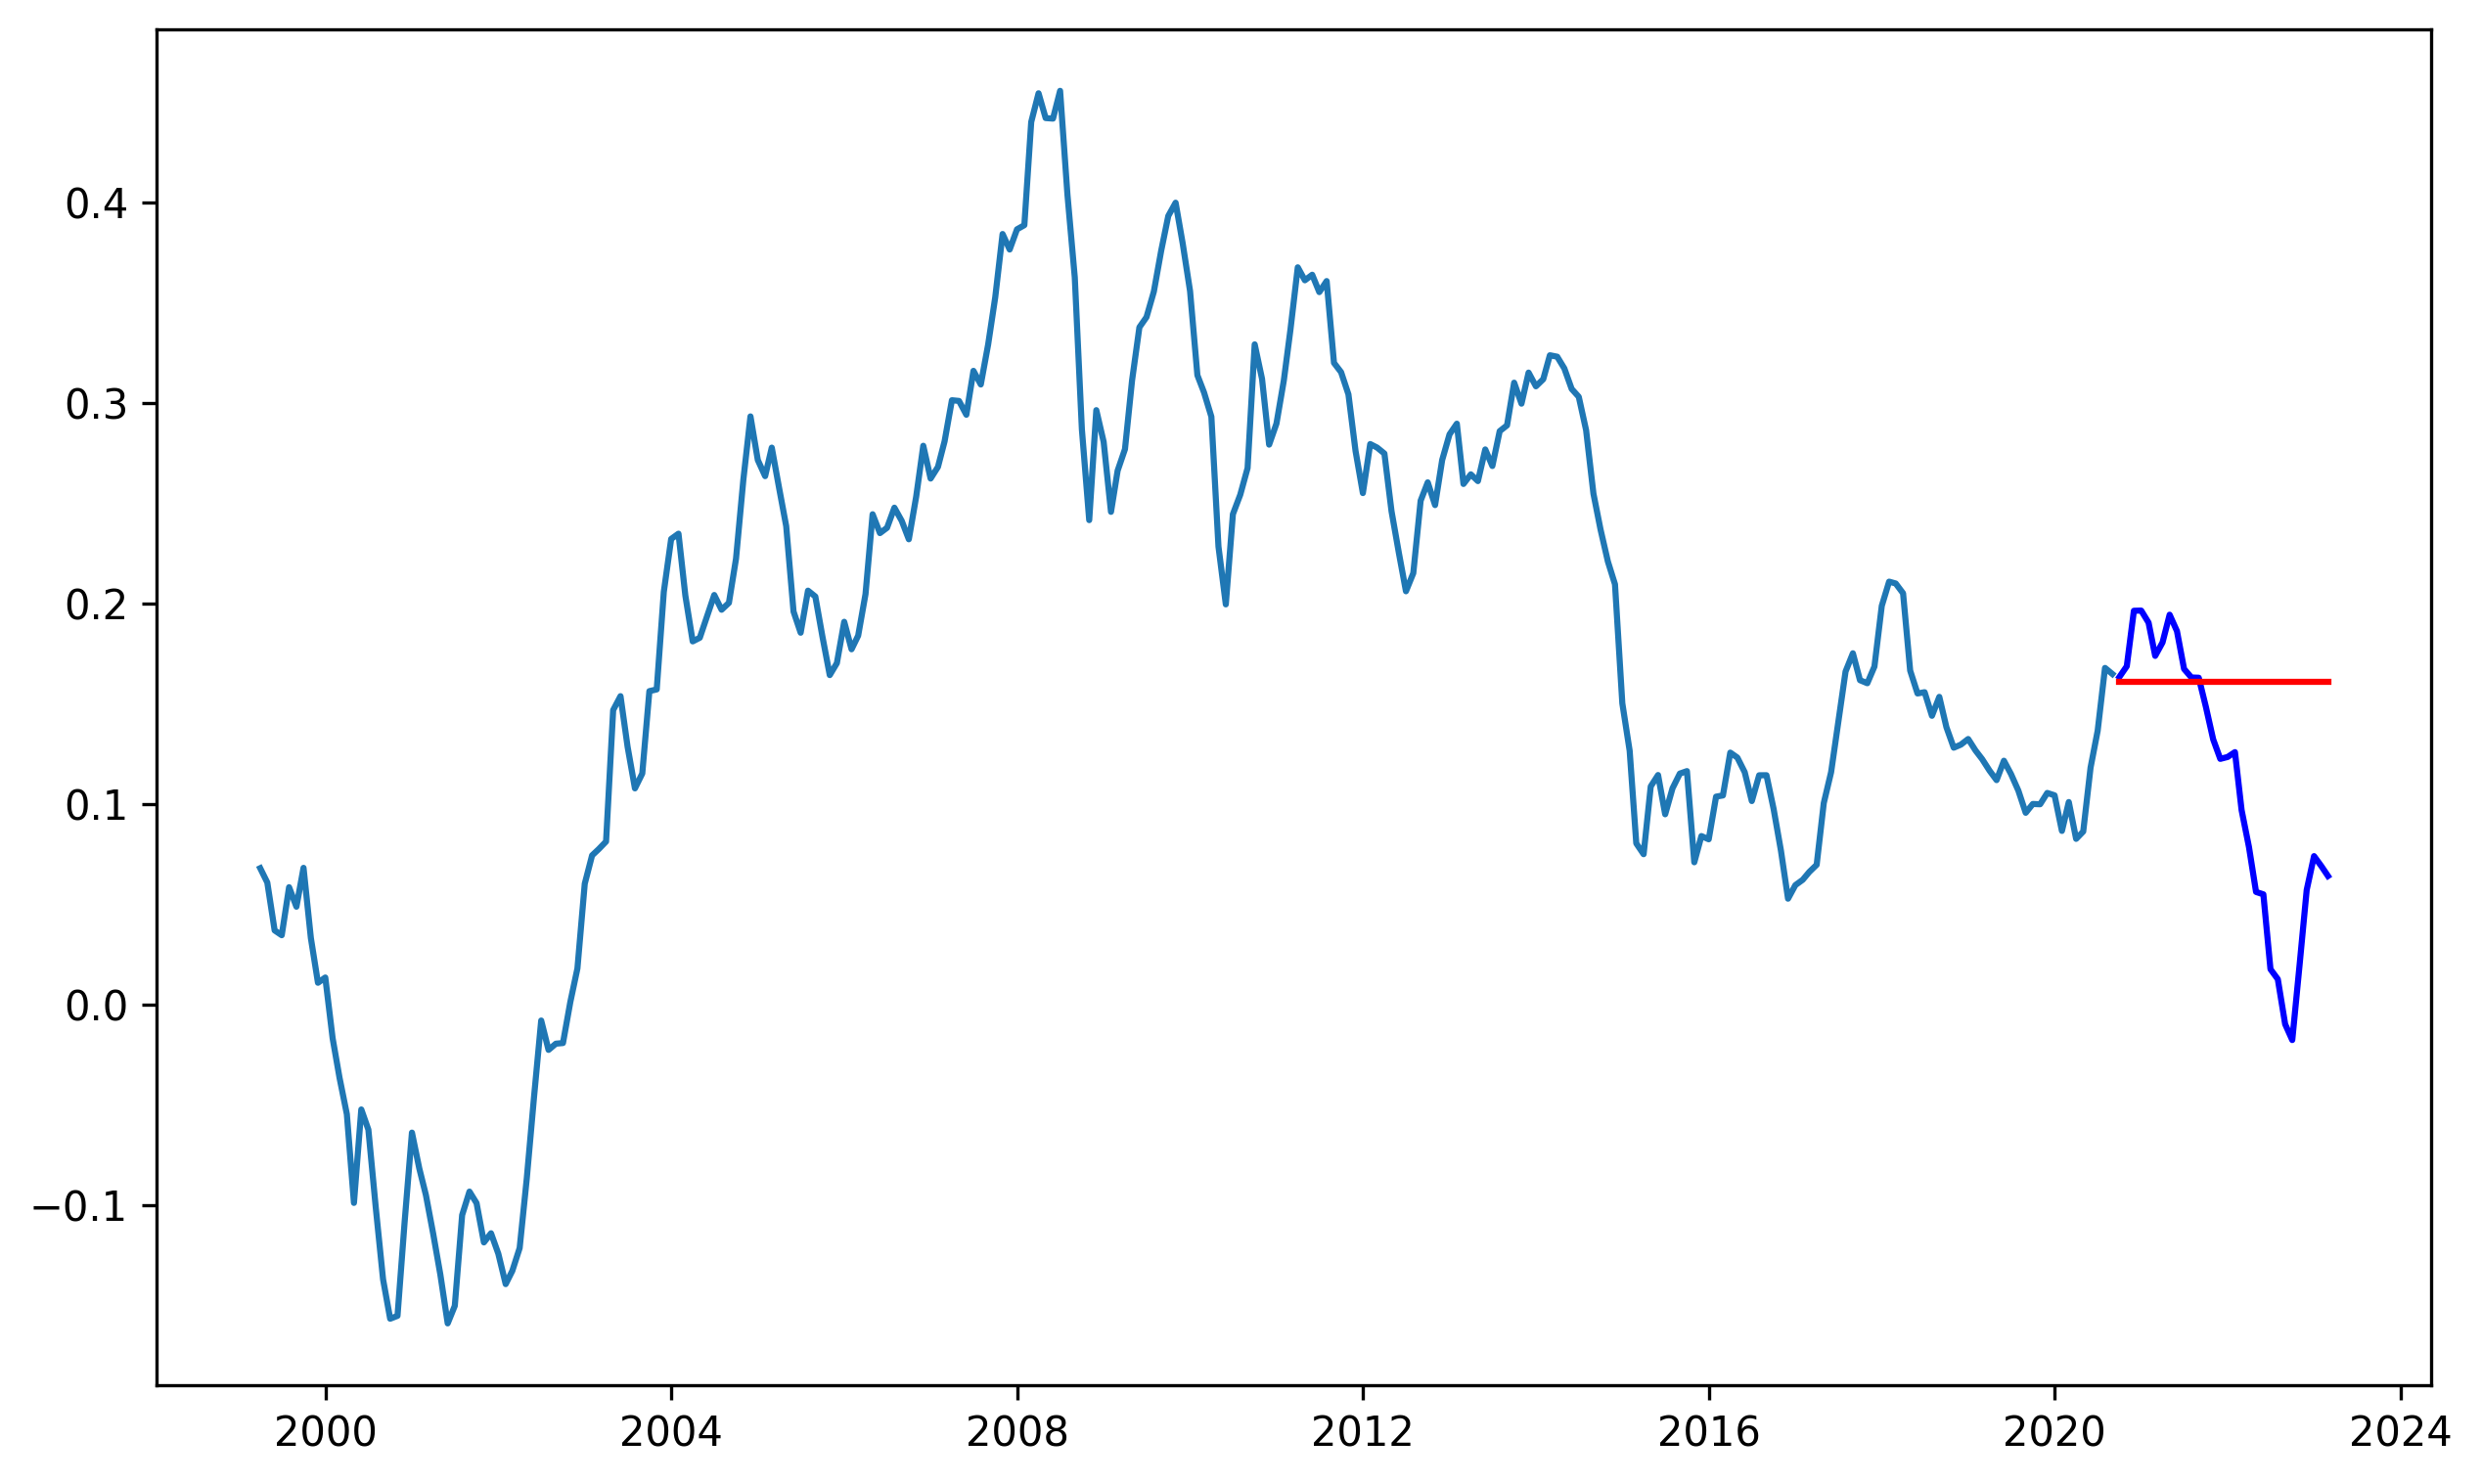

In [27]:
#plot predicted vs actual
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Forex rates')
plt.plot(fc_series, color = 'red',label='Predicted Forex rates')

In [28]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

In [33]:
mse = mean_squared_error(test_data, fc)
mae = mean_absolute_error(test_data, fc)
mape = mean_absolute_percentage_error(test_data, fc)
rmse = np.sqrt(mean_squared_error(test_data, fc))
accuracy = (1-mape)*100

In [34]:
print(f'mse: {mse}')           
print(f'mae: {mae}')
print(f'mape: {mape}')
print(f'rmse: {rmse}')      
print(f'accuracy: {accuracy}')      

mse: 0.006801497643958183
mae: 0.0627849894712114
mape: 2.276744126919163
rmse: 0.08247119281275239
accuracy: -127.6744126919163


In [ ]:
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.models.annotations import Title
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.palettes import Spectral10


source = ColumnDataSource(weekly)

output_notebook()

p = figure(plot_height = 400, \
           plot_width = 800, \
           x_axis_type = 'datetime')

p.line(x='Date', y='USD', legend_label = 'USD', source=source, color=Spectral10[1], line_width=4)
p.line(x='Date', y='JPY', legend_label = 'JPY', source=source, color=Spectral10[2], line_width=4)
p.line(x='Date', y='GBP', legend_label = 'GBP', source=source, color=Spectral10[3], line_width=4)
p.line(x='Date', y='AUD', legend_label = 'AUD', source=source, color=Spectral10[4], line_width=4)
p.line(x='Date', y='CAD', legend_label = 'CAD', source=source, color=Spectral10[5], line_width=4)


p.xaxis[0].ticker.desired_num_ticks = 20

p.xaxis.axis_label = 'Year'
p.yaxis.axis_label = 'Exchange Rate'

t = Title()
t.text = 'Exchange Rate: Top Countries/USD'
p.title = t

hover = HoverTool(tooltips = [
                  ('USD','@USD'),\
                  ('JPY', '@JPY'),\
                  ('GBP', '@GBP'),\
                  ('AUD', '@AUD'),\
                  ('CAD', '@CAD')])
p.add_tools(hover)
show(p)

## Explore data
### Check for stationarity
We need to check the stationarity of the time series, since many models assume that the series is stationary. A time series is stationary when the mean, variance, and covariance of the data are constant and not dependent on time.

### Method 1: Perform the Augmented Dickey-Fuller (ADF)
We can alscheck for staionarity with statistical tests. <br>
The Dickey Fuller test is used to check the stationarity of the series. The test determines how strongly a time series is defined by a trend. The null hypothesis of the test is that time series is not stationary(has some time-dependent structure).
The test result is made up of a Test Statistic and some Critical Values for different confidence levels. <br>If P-VALUE is less than the significance level, the null hypothesis is rejected and the series is stationary.<br>

The most commonly used is the ADF test, where the null hypothesis is the time series possesses a unit root and is non-stationary. The ADF tests give the following results – test statistic, p-value, and critical value at 1%, 5%, and 10% confidence intervals

The test result is made up of a Test Statistic and some Critical Values for different confidence levels. If P-VALUE is less than the significance level , the null hypothesis is rejected and the series is stationary.

if p_value > 0.05 and the stat_value > any of the critical values:
* Acceptiong the Null Hypothesis i.e Dataset is Non-Stationary

else:
* Rejecting the Null Hypothesis i.e Dataset is Stationary

In [ ]:
#The plot of USD/EUR is plotted again by weekly basis for sanity check.
plt.plot(weekly[['USD']])  # focus on USD first


Visualize our data using a method called time-series decomposition that allows us to decompose the time series into three distinct components: trend, seasonality, and noise.
The components are used to understand the different components that contribute to the overall behavior of the time series.<br>
Use the statsmodels package to plot and model the time series data.

In [ ]:
rcParams['figure.figsize'] = 10, 8
decomposition = sm.tsa.seasonal_decompose(weekly['USD'], model='Multiplicative', period=1)
fig = decomposition.plot()

We can see from the plot, there is  no observable trend or seasonality in the differenced time series data.<br>
We can also use another method, called the Dicky-Fuller test, to confirm this observation.

### Smoothing

Moving Average Smoothing is a naive and effective technique in time series forecasting.
Smoothing is a technique applied to time series that can be particulary useful when the time series contains many noise or ourliers. <br>
Calculating a moving average involves creating a new series where the values are comprised of the average of raw observations in the original time series.<br>
A moving average requires that you specify a window size called the window width. This defines the number of raw observations used to calculate the moving average value.

Rolling Statistics: Plot the rolling mean and rolling standard deviation. The time series is stationary if they remain constant with time (with the naked eye look to see if the lines are straight and parallel to the x-axis).

The rolling() function on the Series Pandas object will automatically group observations into a window.<br>
We can specify the window size, and by default, a trailing window is created. Once the window is created, we can use the mean value, which forms our transformed dataset.